## 🗺️ Step 1: Clip Landsat Bands to Chimanimani ROI

In this step, we clip the Landsat 8 bands using a Chimanimani shapefile. This ensures that we only analyze data within our Region of Interest (ROI).

We:
- Load the Red and NIR bands (Band 4 and Band 5).
- Clip them to the Chimanimani shapefile boundary.
- Ensure both bands are spatially aligned.

In [ ]:
pip install rasterio

Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pip/__main__.py", line 8, in <module>
    if sys.path[0] in ("", os.getcwd()):
                           ^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory
Note: you may need to restart the kernel to use updated packages.


## 🌿 Step 2: Compute and Visualize NDVI

We calculate the Normalized Difference Vegetation Index (NDVI) using the formula:

\[
NDVI = \frac{(NIR - RED)}{(NIR + RED)}
\]

This gives us a measure of vegetation health, where:
- Values closer to **1** indicate healthy vegetation.
- Values near **0 or negative** indicate bare ground, urban areas, or water bodies.

We then visualize the NDVI using a colormap (green = high vegetation, red = low).

In [ ]:
import rasterio
import rasterio.mask
import geopandas as gpd
import os

# Load shapefile
shapefile_path = '/Users/freedomkmuranda/Desktop/Desktop from 11 Apr,2025 at 15.55.44/Documents/Chimanimani.shp'
chim_roi = gpd.read_file(shapefile_path)

# Define raster base path
base_path = '/Volumes/USB DISK/CHIMANIMANI_/CHIMANIMANI/Chimanimani_2017:18/Chimanimani_Dec_2017/LC08_L1TP_168074_20171212_20200902_02_T1'
band4_path = os.path.join(base_path, 'LC08_L1TP_168074_20171212_20200902_02_T1_B4.TIF')  # Red
band5_path = os.path.join(base_path, 'LC08_L1TP_168074_20171212_20200902_02_T1_B5.TIF')  # NIR

In [ ]:
from shapely.geometry import mapping

# Match shapefile CRS to raster
with rasterio.open(band4_path) as src_red:
    raster_crs = src_red.crs

chim_roi_proj = chim_roi.to_crs(raster_crs)
geom = [mapping(geom) for geom in chim_roi_proj.geometry]

# Clip and mask Red band (B4)
with rasterio.open(band4_path) as src_red:
    red_data = src_red.read(1).astype('float32')  # Convert to float for NaN
    red_meta = src_red.meta.copy()
    red_meta.update(dtype='float32')
    with rasterio.io.MemoryFile() as memfile:
        with memfile.open(**red_meta) as tmp_ds:
            tmp_ds.write(red_data, 1)
            red_clipped, red_transform = rasterio.mask.mask(tmp_ds, geom, crop=True, filled=True, nodata=np.nan)

# Clip and mask NIR band (B5)
with rasterio.open(band5_path) as src_nir:
    nir_data = src_nir.read(1).astype('float32')
    nir_meta = src_nir.meta.copy()
    nir_meta.update(dtype='float32')
    with rasterio.io.MemoryFile() as memfile:
        with memfile.open(**nir_meta) as tmp_ds:
            tmp_ds.write(nir_data, 1)
            nir_clipped, nir_transform = rasterio.mask.mask(tmp_ds, geom, crop=True, filled=True, nodata=np.nan)

# Get arrays
red = red_clipped[0]
nir = nir_clipped[0]

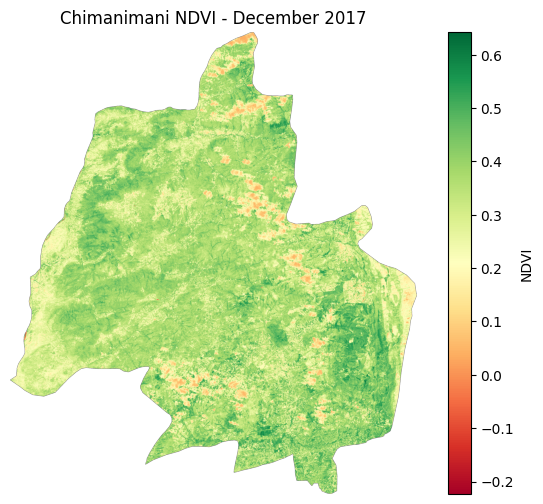

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# NDVI calculation with NaNs preserved
ndvi = (nir - red) / (nir + red + 1e-10)

# Mask out invalid values
ndvi = np.where(np.isnan(red) | np.isnan(nir), np.nan, ndvi)

# Plot clipped NDVI only 
plt.figure(figsize=(8, 6))
ndvi_plot = plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar(ndvi_plot, label='NDVI')
plt.title('Chimanimani NDVI - December 2017')
plt.axis('off')
plt.show()

In [ ]:
pip install seaborn


[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: pip3.12 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install pandas


[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: pip3.12 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install numpy


[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: pip3.12 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## 📊 Step 3: NDVI Histogram and Summary Statistics

To better understand the distribution of NDVI values across the clipped area, we:
- Plot a histogram using Seaborn to visualize the frequency of NDVI values.
- Compute basic statistics like **mean**, **min**, **max**, and **standard deviation**.

This gives us insight into overall vegetation conditions in Chimanimani for the selected date.

NDVI Summary Statistics:
count    3.682074e+06
mean     3.488249e-01
std      8.946868e-02
min     -2.234100e-01
25%      3.010727e-01
50%      3.620313e-01
75%      4.073802e-01
max      6.426957e-01
dtype: float64


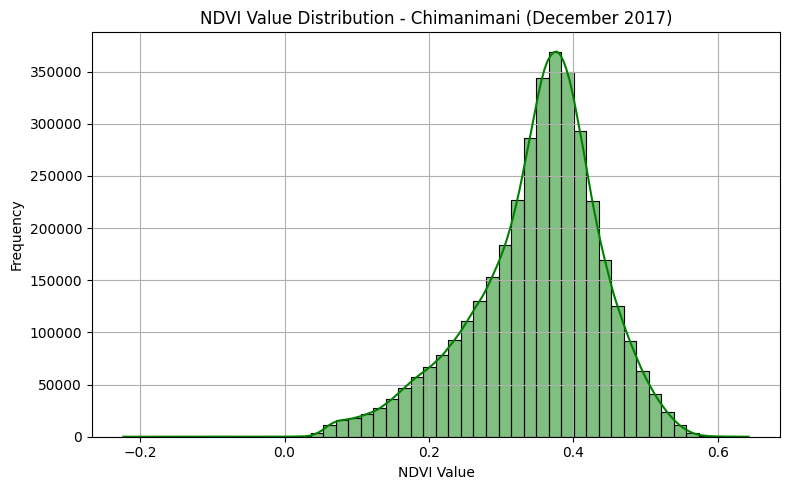

In [ ]:
import seaborn as sns
import pandas as pd

# Flatten and filter out NaN values
ndvi_flat = ndvi.flatten()
ndvi_clean = ndvi_flat[~np.isnan(ndvi_flat)]

# Summary statistics
ndvi_stats = pd.Series(ndvi_clean).describe()
print("NDVI Summary Statistics:")
print(ndvi_stats)

# Plot histogram
plt.figure(figsize=(8, 5))
sns.histplot(ndvi_clean, bins=50, kde=True, color='green')
plt.title('NDVI Value Distribution - Chimanimani (December 2017)')
plt.xlabel('NDVI Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()